@author Nassir Mohammad

# Preliminaries

In [1]:
import sys 
sys.path.append('../')
sys.path.append('../scripts')

import warnings
from perception_nassir import Perception

import dataframe_image as dfi

import numpy as np
import pandas as pd
from scipy.io import loadmat

import seaborn as sns

from pyod.models.mcd import MCD
from sklearn.cluster import DBSCAN

from utilities import apply_classifiers

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from rendering_functions import highlight_max, highlight_min

image_save_path = ''
image_save_switch = False

# ex8data2

Dataset taken from: Andrew Ng. Machine learning: Programming Exercise 8: Anomaly Detection and Recommender Systems. 2012.

## Read and explore the data

In [2]:
data_path = r"../data/ex8data2.mat"
data = loadmat(data_path)
X2 = data['X']
X2_val = data['Xval']
y2_val = data['yval']

# show the headers
for key, val in data.items():
    print(key)
    
print("The shape of X2 is: {}".format(X2.shape))
print("The shape of X2_val is: {}".format(X2_val.shape))
print("The shape of y2 is: {}".format(y2_val.sum()))

__header__
__version__
__globals__
X
Xval
yval
The shape of X2 is: (1000, 11)
The shape of X2_val is: (100, 11)
The shape of y2 is: 10


### Standarise and view the data

In [3]:
sc = StandardScaler()
sc.fit(X2)
X2 = sc.transform(X2)
X2_val = sc.transform(X2_val)

/Users/nassirmohammad/anaconda3/envs/conda_arm1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nassirmohammad/anaconda3/envs/conda_arm1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nassirmohammad/anaconda3/envs/conda_arm1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nassirmohammad/anaconda3/envs/conda_arm1/lib/python3.11/site-packages/seaborn/_oldcore.py:111

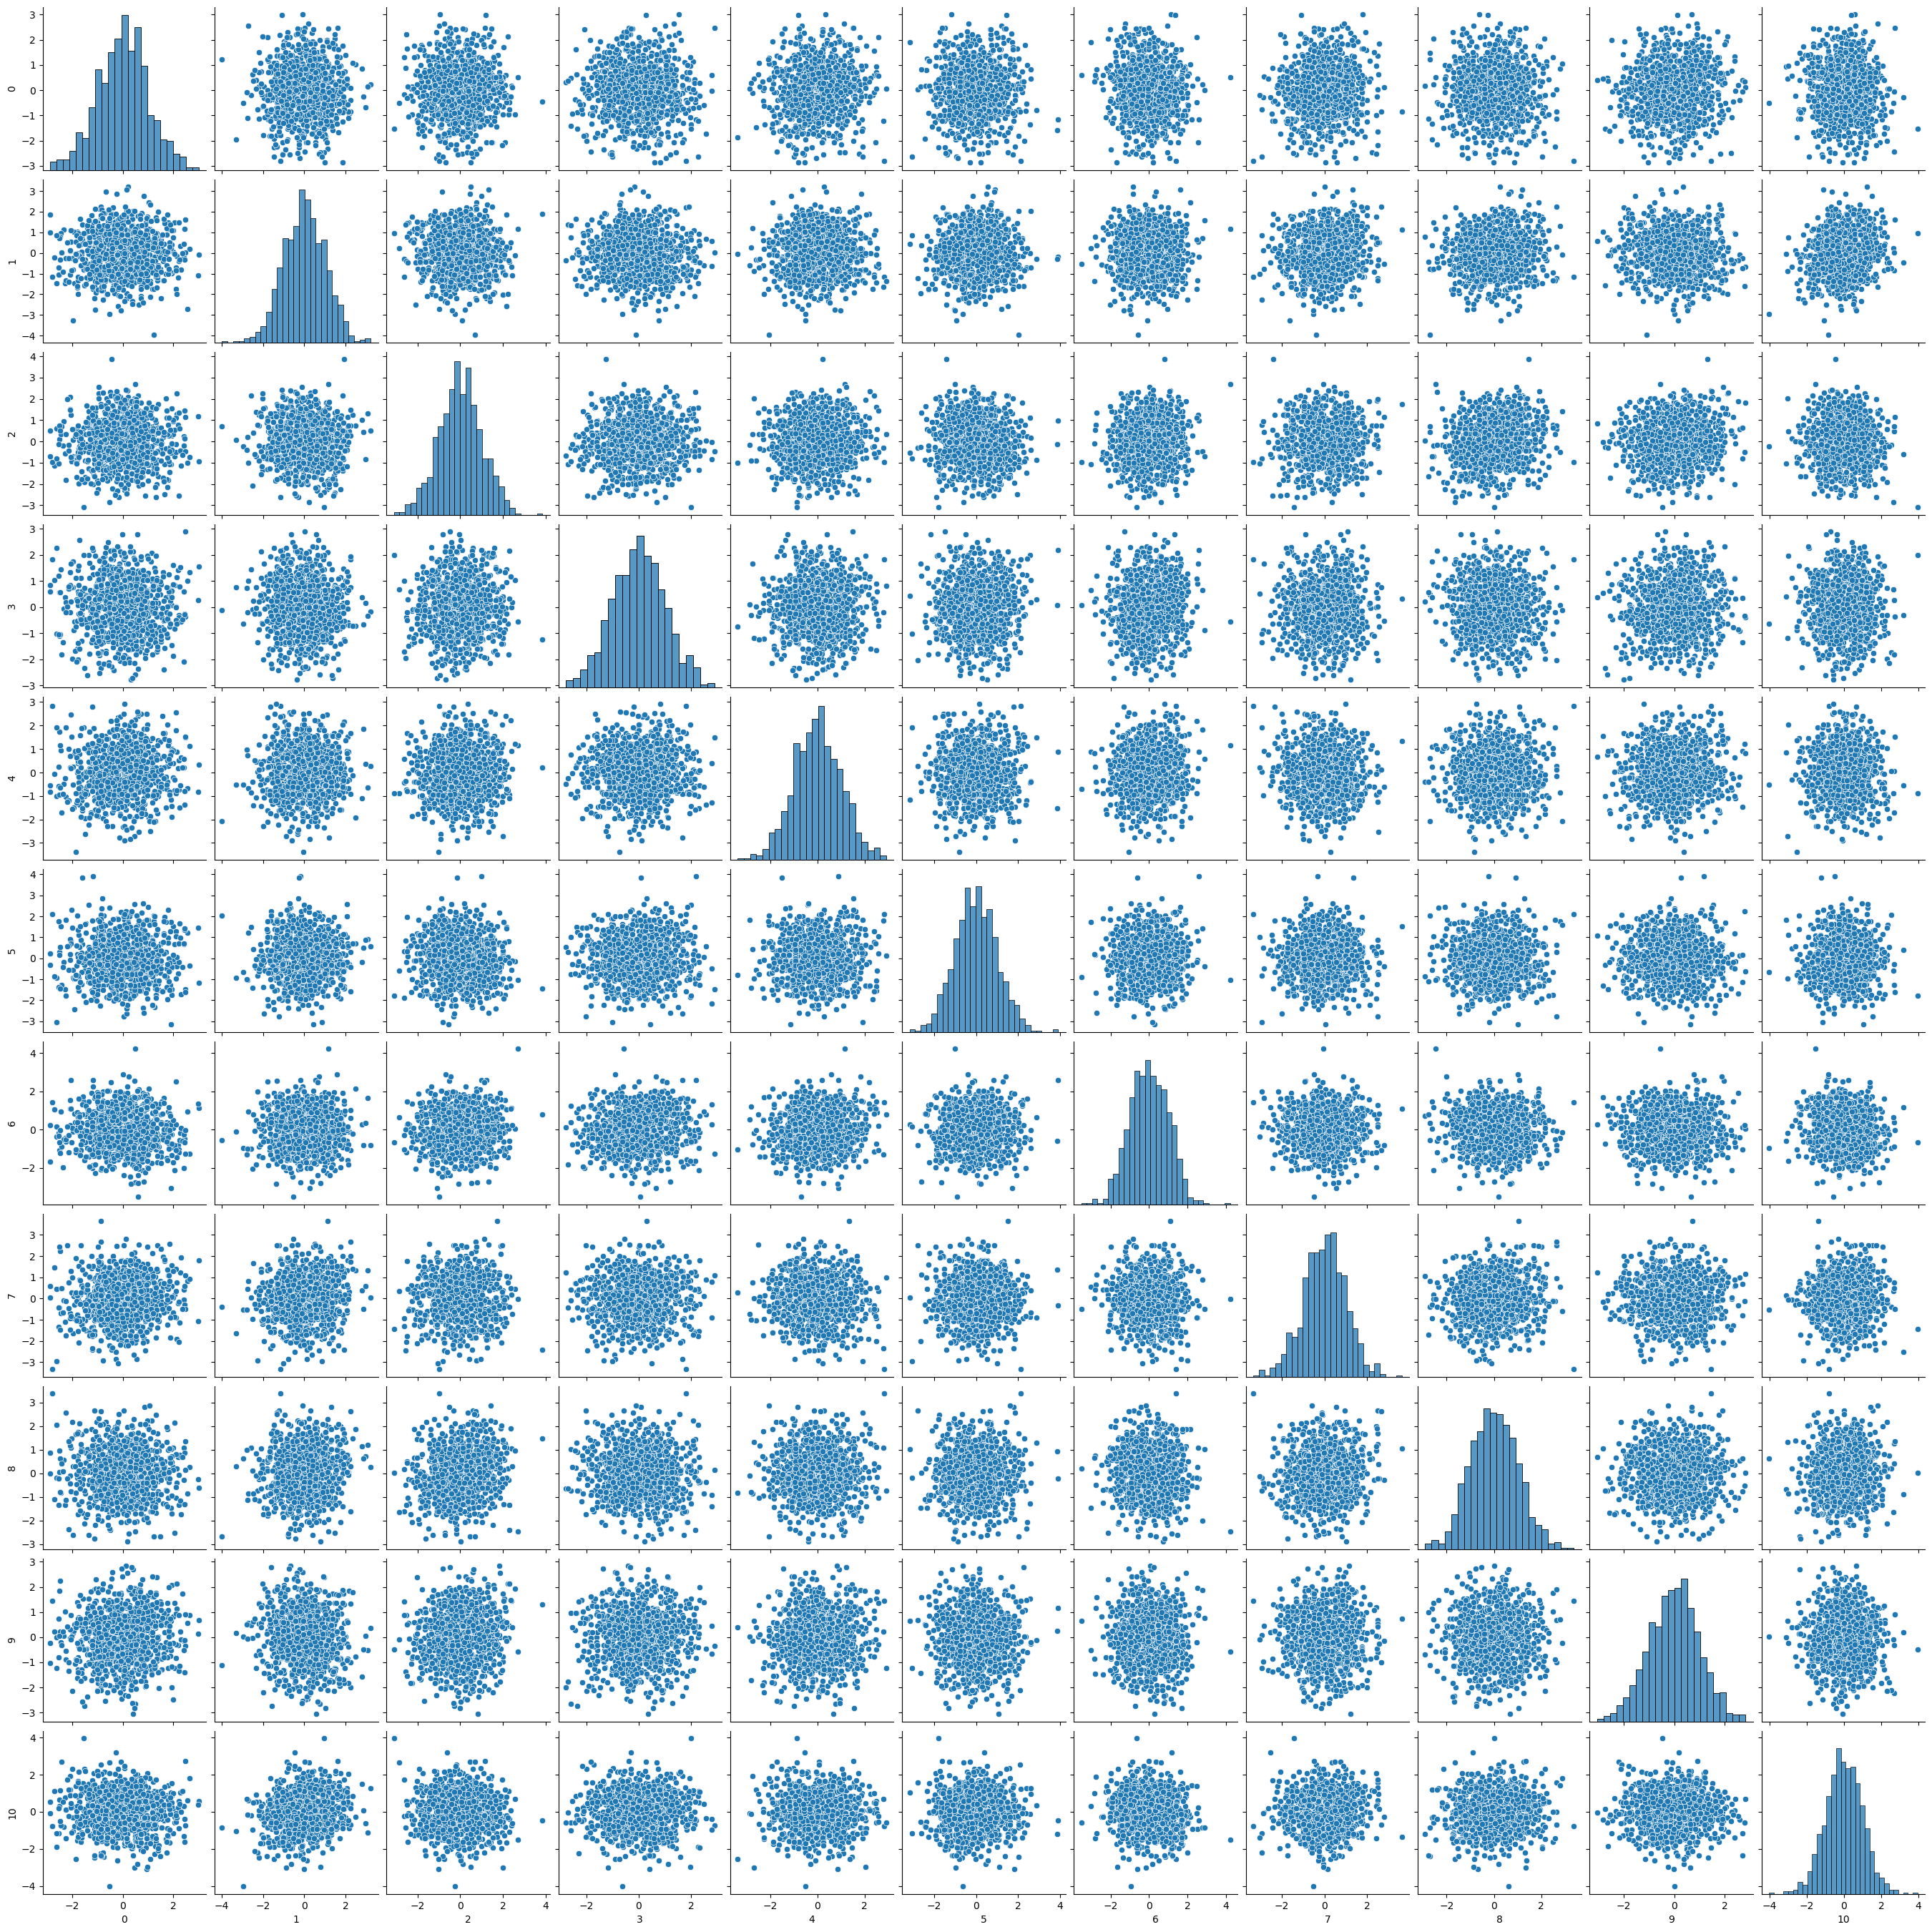

In [4]:
df = pd.DataFrame(X2)
sns.pairplot(df);

/Users/nassirmohammad/anaconda3/envs/conda_arm1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nassirmohammad/anaconda3/envs/conda_arm1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nassirmohammad/anaconda3/envs/conda_arm1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nassirmohammad/anaconda3/envs/conda_arm1/lib/python3.11/site-packages/seaborn/_oldcore.py:111

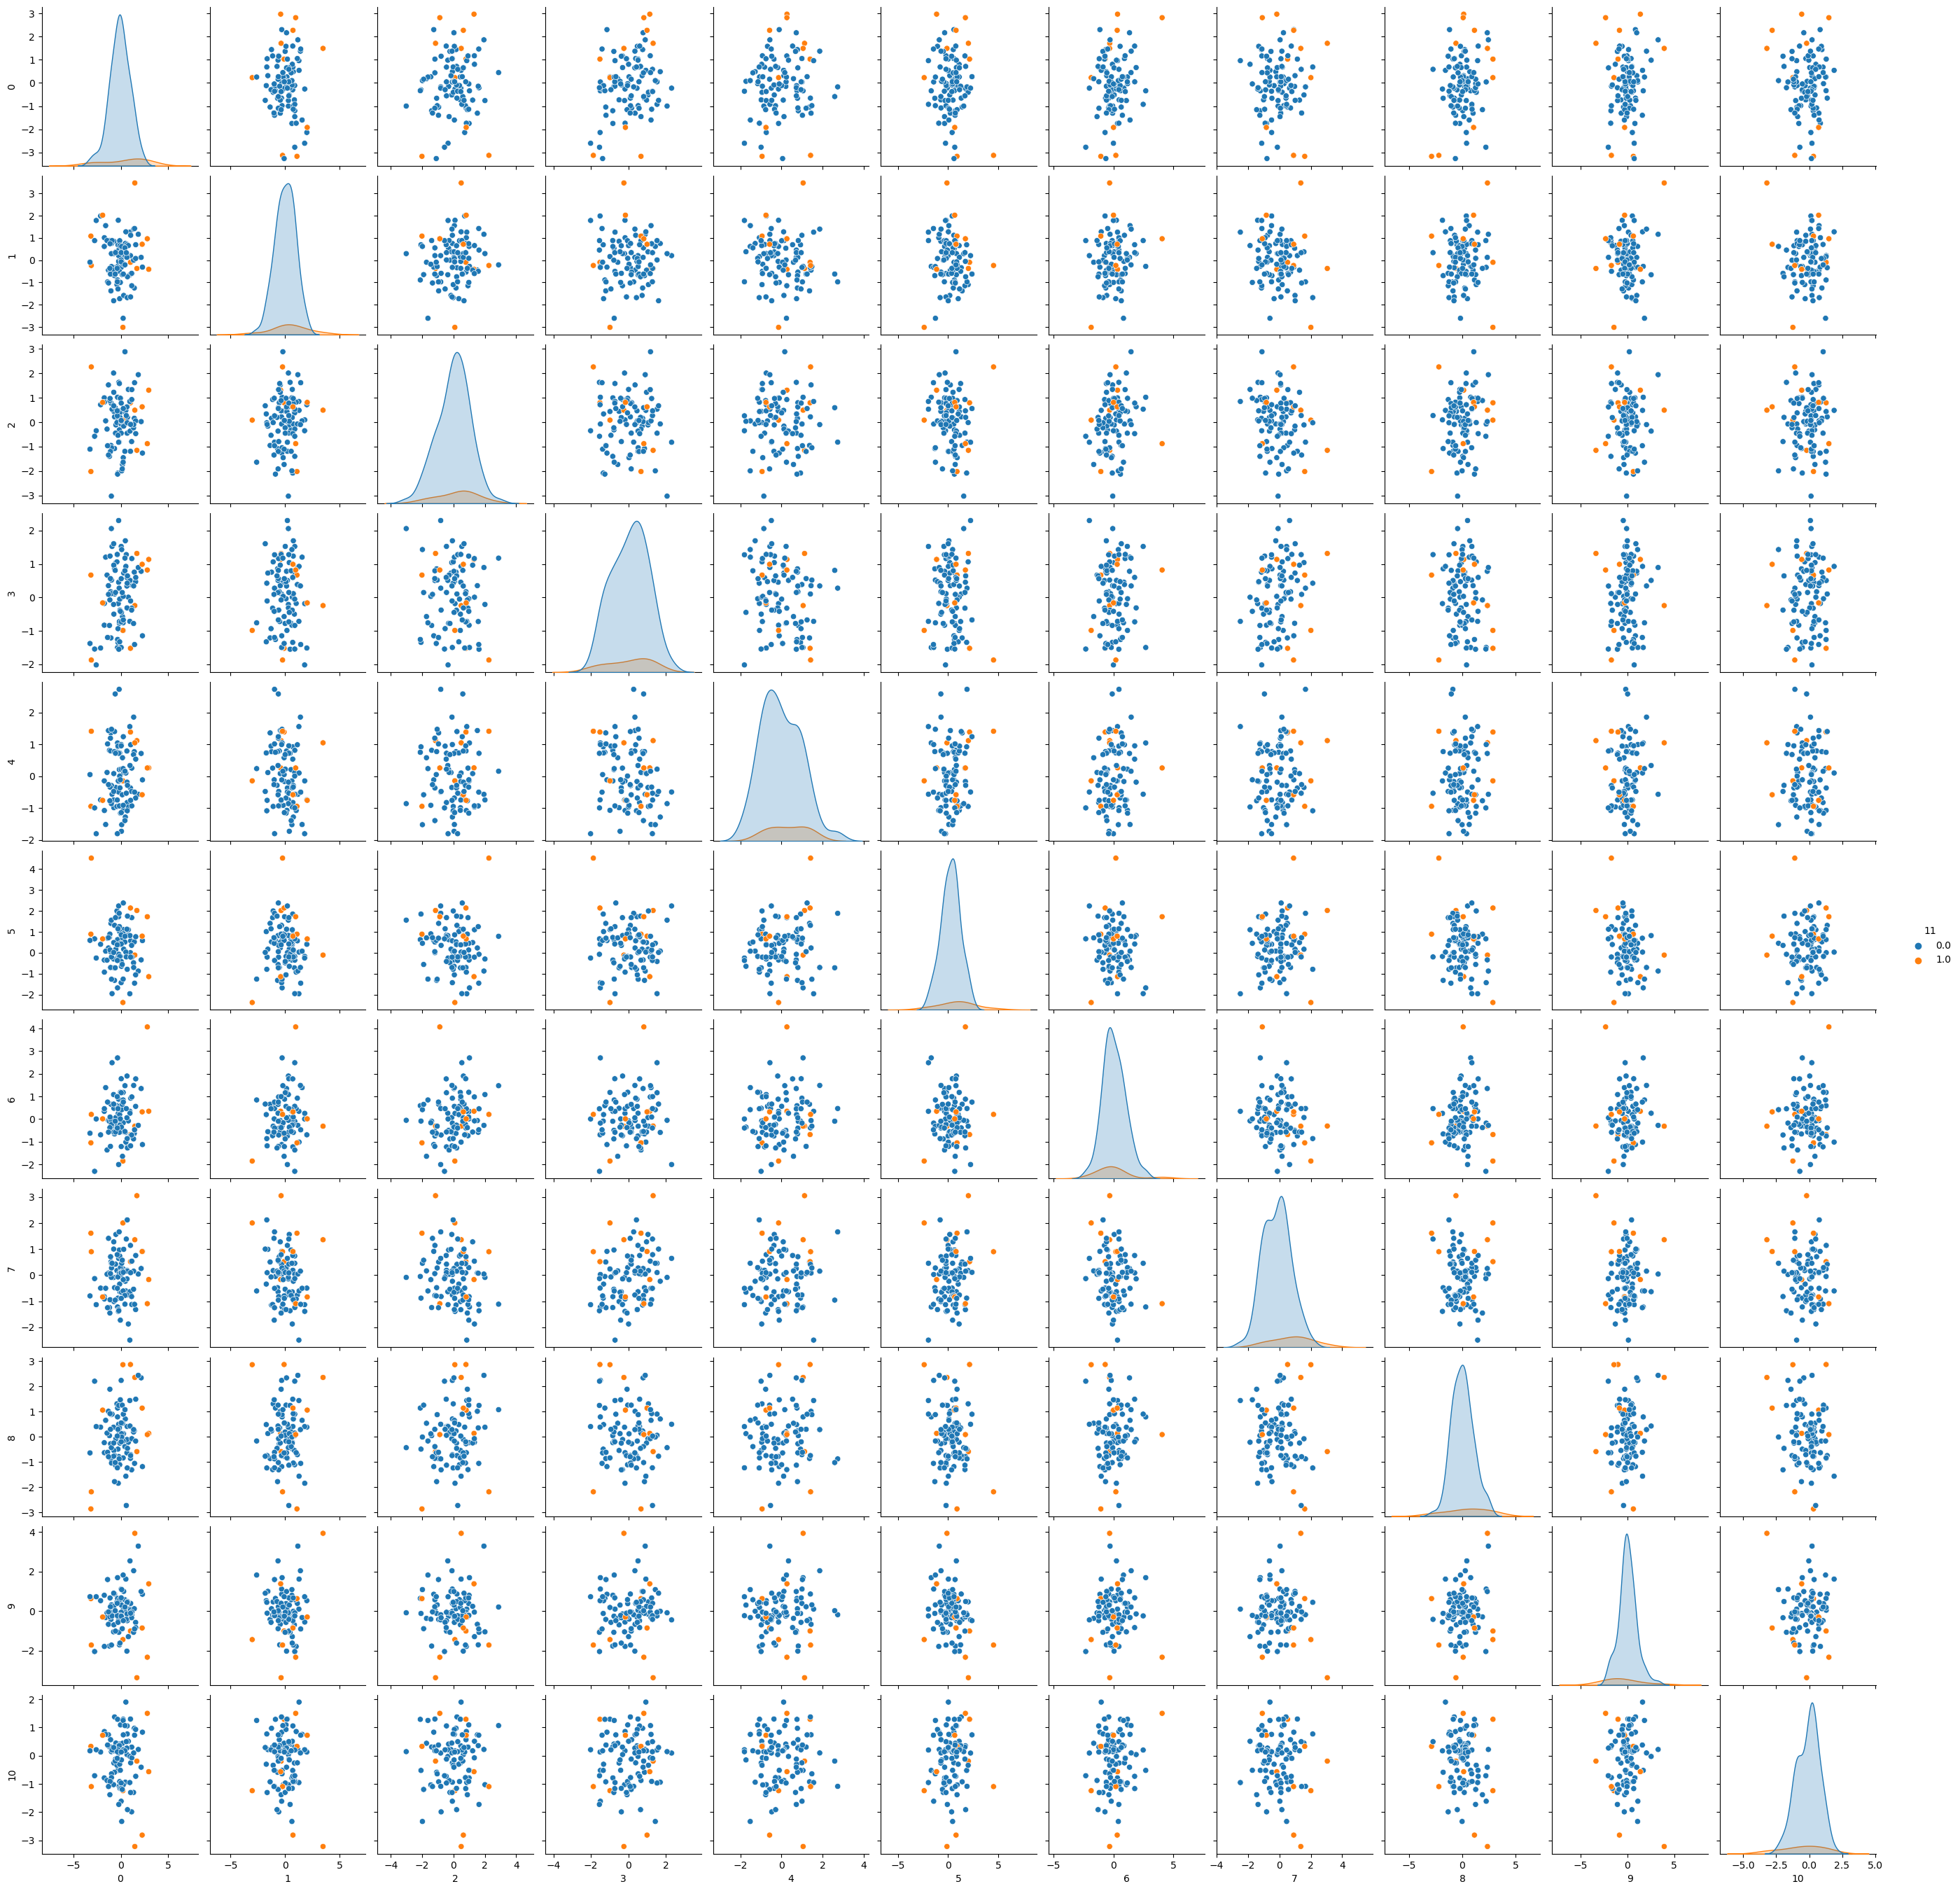

In [5]:
# view the validation data with labels
df2 = pd.DataFrame(np.append(X2_val, y2_val, 1))
sns.pairplot(df2, hue=11);

### MCD

In [6]:
clf_mcd = MCD(random_state=42)
clf_mcd.fit(X2)
validation_labels = clf_mcd.predict(X2_val)
scores = clf_mcd.decision_function(X2_val)

print(classification_report(y2_val, validation_labels, 
                            target_names=['normal', 'abnormal'],output_dict=False))

auc_score = roc_auc_score(y2_val, scores)
print('auc score: {}'.format(auc_score))

              precision    recall  f1-score   support

      normal       0.98      0.89      0.93        90
    abnormal       0.44      0.80      0.57        10

    accuracy                           0.88       100
   macro avg       0.71      0.84      0.75       100
weighted avg       0.92      0.88      0.89       100

auc score: 0.9388888888888889


### Perception 

In [7]:
clf_perception = Perception()
clf_perception.fit(X2)
clf_perception.predict(X2_val)

validation_labels = clf_perception.labels_

print(classification_report(y2_val, validation_labels, 
                            target_names=['normal', 'abnormal'],output_dict=False))

auc_score = roc_auc_score(y2_val, clf_perception.scores_)
print('auc score: {}'.format(auc_score))

              precision    recall  f1-score   support

      normal       0.96      0.98      0.97        90
    abnormal       0.75      0.60      0.67        10

    accuracy                           0.94       100
   macro avg       0.85      0.79      0.82       100
weighted avg       0.94      0.94      0.94       100

auc score: 0.8588888888888889


### DBSCAN

In [8]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    clf_dbscan = DBSCAN()
    clustering = clf_dbscan.fit(X2_val) # likely not enough data to be used this way

    validation_labels = np.where(clustering.labels_ == -1, 1, 0)

    print(classification_report(y2_val, validation_labels,
                                target_names=['normal', 'abnormal'],output_dict=False))

    auc_score = roc_auc_score(y2_val, validation_labels)
    print('auc score: {}'.format(auc_score))

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00        90
    abnormal       0.10      1.00      0.18        10

    accuracy                           0.10       100
   macro avg       0.05      0.50      0.09       100
weighted avg       0.01      0.10      0.02       100

auc score: 0.5


# Apply all models

In [9]:
dataset_name = 'ex8data2'
classifiers = [
    'HBOS',  # to be ignored, first run in loop slower
    'HBOS',
    'IForest',
    'KNN',
    'LOF',
    'MCD',
    'OCSVM',
    'Perception',
    # 'DBSCAN',
]

df = apply_classifiers(classifiers, dataset_name,
                       predict_data=X2_val,
                       predict_labels=y2_val,
                       train_data=X2)

current classifier in progress: HBOS
total run time: 1.8662964180111885
current classifier in progress: HBOS
total run time: 0.001586749916896224
current classifier in progress: IForest
total run time: 0.067919832887128
current classifier in progress: KNN
total run time: 0.018285457976162434
current classifier in progress: LOF
total run time: 0.017249250086024404
current classifier in progress: MCD
total run time: 0.20382099994458258
current classifier in progress: OCSVM
total run time: 0.03997387480922043
current classifier in progress: Perception
total run time: 0.0009553339332342148


In [11]:
cols = ['Precision', 'Recall', 'F1', 'AUC']
formatdict = {}
for col in cols: formatdict[col] = "{:.2f}"
formatdict.pop('Classifier', None)
formatdict['Runtime'] = "{:.5f}"
    
metrics_df_styled = df.style.hide().apply(highlight_max, 
                                                 subset=['Precision', 'Recall', 'F1', 
                                                         'AUC']).\
apply(highlight_min, subset=['Runtime']).format(formatdict)
metrics_df_styled

In [ ]:
# title_img = 'Anomaly detection results on dataset ex8data2'    
# path = image_save_path + 'ex8data2_validation_table.png'

# dfi.export(metrics_df_styled,path)